In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [111]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import numpy as np
import utils as u
from sklearn.metrics.pairwise import cosine_similarity

In [112]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"
audio_file_path = "audios/ggk1.wav"
pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

# Use median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic, percussive = pp.apply_median_filtering(spectrogram)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print("Harmonic component:")
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print("Percussive component:")
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


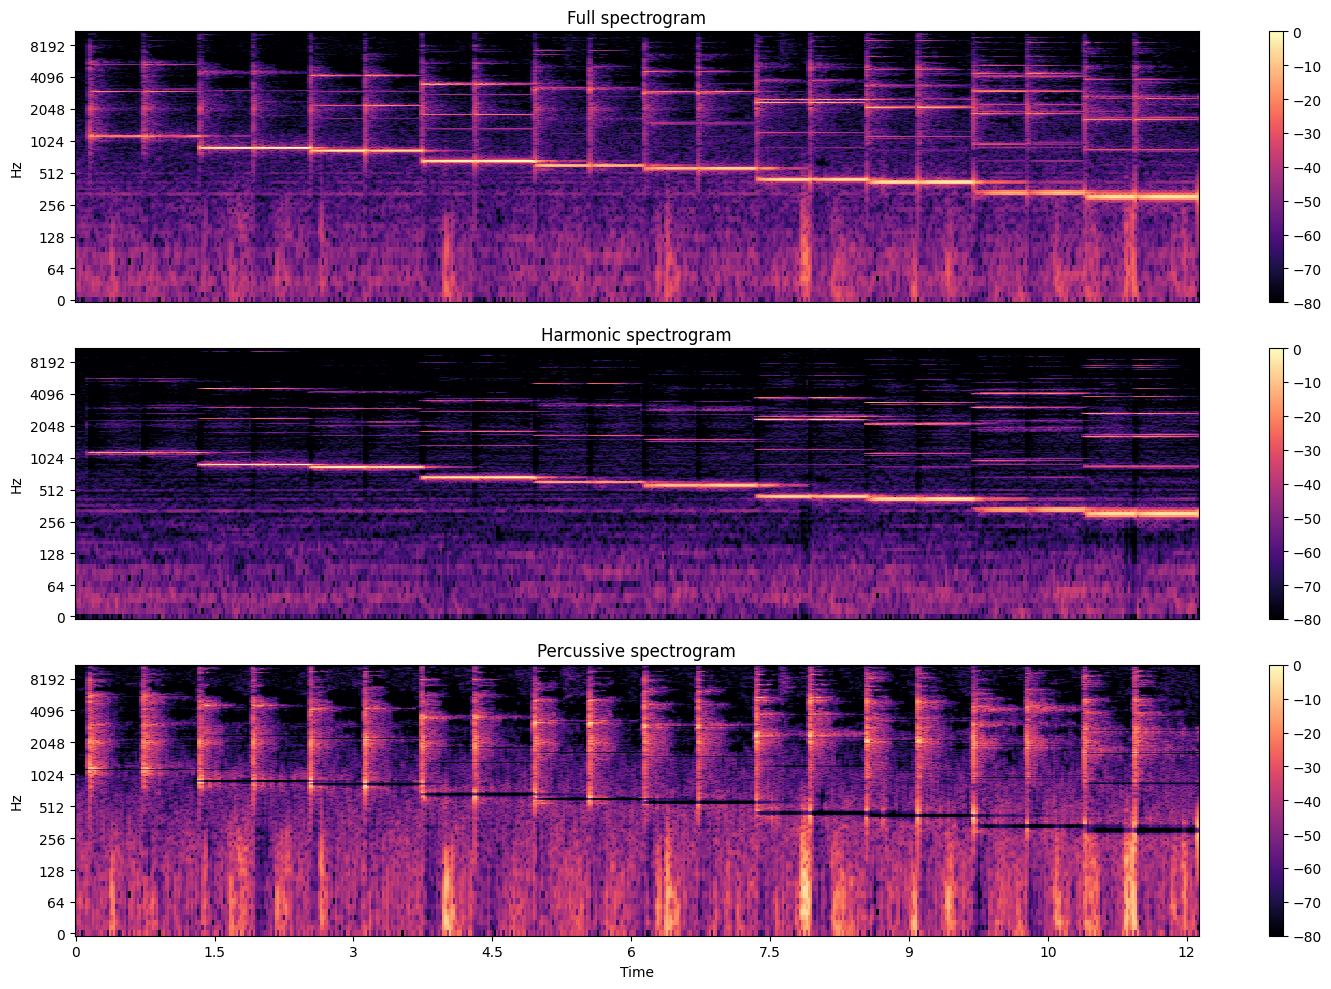

In [113]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

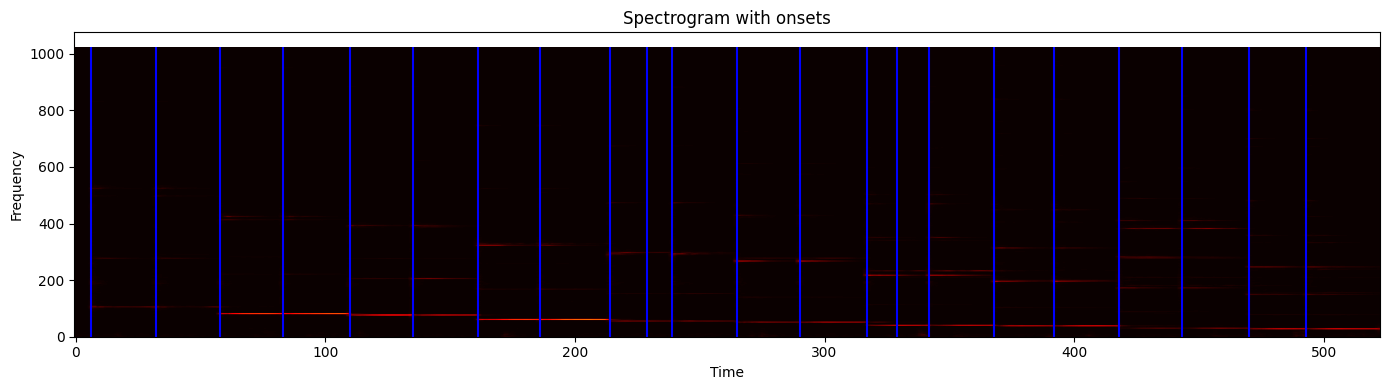

In [114]:
onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect="auto", origin="lower", cmap="hot")

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color="blue", linestyle="-")

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.set_title("Spectrogram with onsets")

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [115]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [116]:
# TODO: for simplicity get rid of pitch_est class and replace it with simple crepe.predict()
time, frequency, confidence, activation = pitch_est.estimate_crepe(harmonic_audio, sr, use_viterbi=False)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step


In [117]:
new_frequency = frequency.copy()
new_frequency[confidence < 0.5] = 0

In [118]:
# NOT IN USE
# import utils as u
# seg = u.segment_stable_frequency_regions(new_frequency, stdThsld=5, minNoteDur=0.5, winStable=5, fs=sr, H=512)

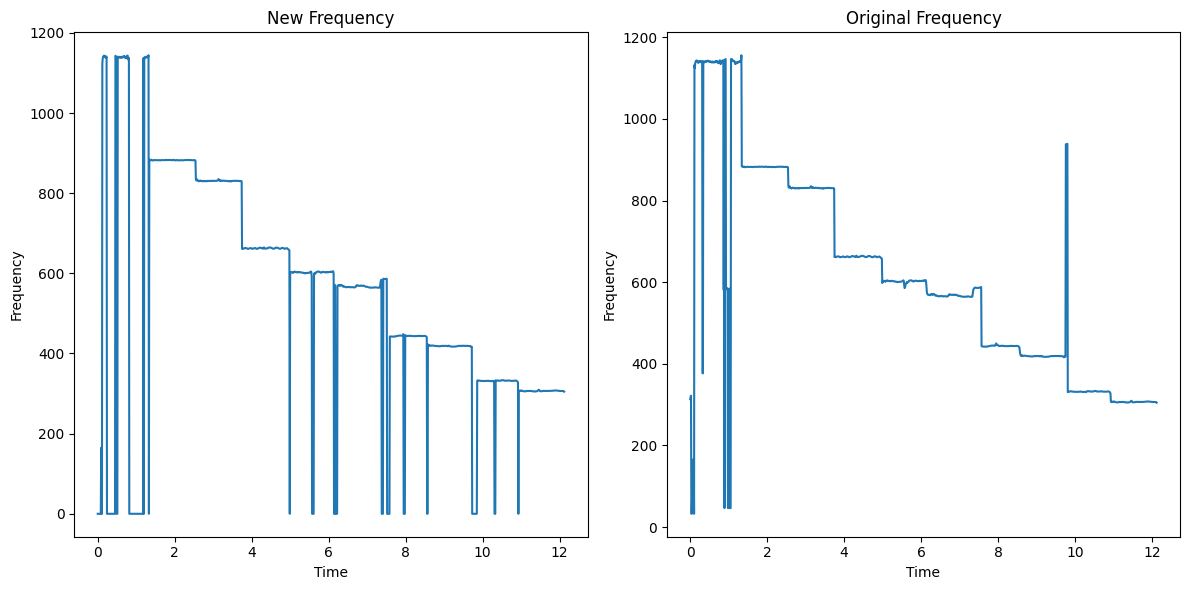

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot new_frequency
ax1.plot(time, new_frequency)
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")
ax1.set_title("New Frequency")

# Plot frequency
ax2.plot(time, frequency)
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")
ax2.set_title("Original Frequency")

plt.tight_layout()
plt.show()

In [147]:
tones = []
stable_segments_idxs = []


for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1:
        index_b = len(time) - 1
    else:
        index_b = np.argmax(time > onsets[i + 1])

    # this was an attempt to try to get the frequency with the highest confidence value. 
    #  not working :-(
    # most_confident_idx = np.argmax(confidence[index_a:index_b])
    # fq = new_frequency[most_confident_idx]
    # # print(fq)
    # tones.append(fq)

    frequency_segment = new_frequency[index_a:index_b]
    stable_freq_seg = u.select_stable_part(frequency_segment, threshold=0.5)

    
    # # Calculate time indices for stable segment
    # stable_index_a = time[index_a + np.argmax(frequency_segment == stable_freq_seg[0])]
    # stable_index_b = time[index_a + np.argmax(frequency_segment == stable_freq_seg[-1]) + 1]

    # # Store the time indices of the stable segment
    # stable_segments_idxs.append((stable_index_a, stable_index_b))

    print("original segment:", frequency_segment, "\n")
    print("stable segment:", stable_freq_seg, "\n")
    tone = np.median(stable_freq_seg)
    if tone == 0: continue
    print(f'Onset median {i}-{i+1}: {tone}')
    print(f'Onset mean {i}-{i+1}: {np.mean(stable_freq_seg)}', "\n")

    print("----------")
    tones.append(tone)

    # if i == 57:
    # #     audio = harmonic_audio[int(onset*sr):int(onsets[i+1]*sr)]
    # #     display(ipd.Audio(audio, rate=sr))
    # #     plt.plot(audio)


original segment: [1140.56238056 1140.51129758 1142.87278942 1143.14515232 1141.25496738
 1142.1185111  1139.10157498 1137.2705062  1138.54482262 1140.84687177
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.         1142.84675192 1141.75308311 1140.2710136
    0.            0.            0.         1140.73899868 1139.18265647
 1140.06913671 1138.33819836 1139.82058502 1140.39862947 1138.57140152
 1139.96215394 1138.49115821 1138.69764798 1140.13785385 1138.33637799
 1139.50492736 1140.6207022  1139.11926458 1140.61499542 1142.07529184
 1140.73256643 1141.32530363 1138.28666691 1136.90104813 1136.98939445
 1136.80906617] 

stable segment: [1140.56238056 1140.51129758 1142.87278942 1143.14515232 1141.25496738
 1142.1185111  1139.10157498 1137.2705062  1138.54482262 1

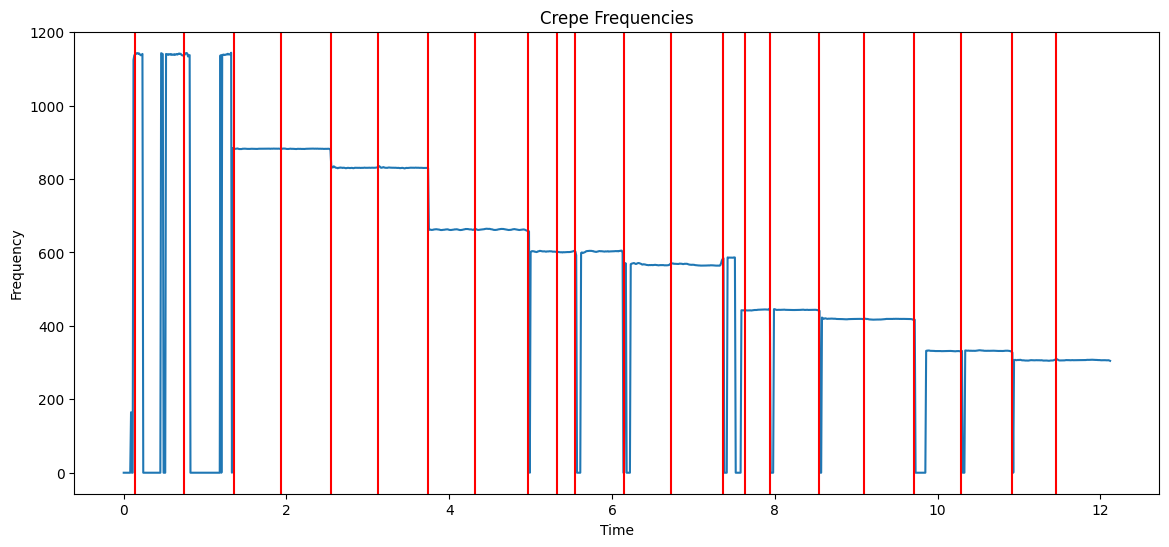

In [141]:
# for t in tones:
#     audio = librosa.tone(t, duration=1)
#     print(f'Playing t {t}')
#     display(ipd.Audio(audio, rate=sr))

plt.figure(figsize=(14, 6))  # Adjust the size as needed

# Plot the interpolated frequencies
plt.plot(time, new_frequency)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Crepe Frequencies")

for t in onsets:
    plt.axvline(x=round(t, 2), color="r", linestyle="-", label=f"Time {t}")


# # Plot stable segments
# for idxs in stable_segments_idxs:
#     plt.axvspan(idxs[0], idxs[1], color='green', alpha=0.5)
# plt.show()

In [142]:
tone_group = u.group_and_average_frequencies(tones)
print(tone_group)

[306.4512430104248, 331.82121902525023, 418.86567726601703, 443.2789251193526, 565.7738826971791, 602.3523689379107, 662.499383703806, 830.6832285162234, 882.4837321069048, 1138.3363779912684]


In [143]:
for tone in tone_group:
    audio = librosa.tone(tone, duration=1)
    print(f"Playing tone {tone}")
    display(ipd.Audio(audio, rate=sr))

Playing tone 306.4512430104248


Playing tone 331.82121902525023


Playing tone 418.86567726601703


Playing tone 443.2789251193526


Playing tone 565.7738826971791


Playing tone 602.3523689379107


Playing tone 662.499383703806


Playing tone 830.6832285162234


Playing tone 882.4837321069048


Playing tone 1138.3363779912684


## Find out the tuning

In [138]:
def compute_distance(tone_a, tone_b):
    distance_in_cents = 1200 * np.log2(tone_b / tone_a)
    return distance_in_cents

distances = []
for i in range(len(tone_group) - 1):
    tone_a = tone_group[i]
    tone_b = tone_group[i + 1]
    d = compute_distance(tone_a, tone_b)
    print(f"Distance between {tone_a} and {tone_b}: {d} cents")
    distances.append(d)

Distance between 306.4524334467998 and 331.8893664799343: 138.0470955564814 cents
Distance between 331.8893664799343 and 418.878044407579: 402.9934318067437 cents
Distance between 418.878044407579 and 443.7831857209727: 99.98968804547715 cents
Distance between 443.7831857209727 and 565.8611144748006: 420.7115915430277 cents
Distance between 565.8611144748006 and 585.8649056190097: 60.1440389831934 cents
Distance between 585.8649056190097 and 602.4108513566615: 48.21567043494186 cents
Distance between 602.4108513566615 and 662.499383703806: 164.60562559486428 cents
Distance between 662.499383703806 and 830.6832285162234: 391.65517709064375 cents
Distance between 830.6832285162234 and 882.4837321069048: 104.72550834679538 cents
Distance between 882.4837321069048 and 1139.6556530069684: 442.74766930078084 cents


In [125]:
for i in range(len(distances) - 1):
    if distances[i] < 220 and distances[i+1] < 220:
        print(f"Found two consecutive values smaller than 220: {distances[i]} and {distances[i+1]}")
        scale = tone_group[i:i+6]
        scale_distances = np.array(distances[i:i+5])
        ding, dong, deng, dung, dang, hiding = scale
        break
print("---")
print(f"Ding: {ding}")
print(f"Dong: {dong}")
print(f"Deng: {deng}")
print(f"Dung: {dung}")
print(f"Dang: {dang}")
print(f"Hiding: {hiding}")
print("---")
print(f"Scale distances: {scale_distances}")

Found two consecutive values smaller than 220: 108.45853540236952 and 164.77370302781904
---
Ding: 565.7738826971791
Dong: 602.3523689379107
Deng: 662.499383703806
Dung: 830.6832285162234
Dang: 882.4837321069048
Hiding: 1138.3363779912684
---
Scale distances: [108.4585354  164.77370303 391.65517709 104.72550835 440.74241726]


In [130]:
begbeg = np.array([120, 114, 432, 81, 453])
sedang = np.array([136, 155, 379, 134, 396])
tirus = np.array([197, 180, 347, 104, 372])

similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
print(f"Similarity to begbeg: {similarity[0]}")
print(f"Similarity to sedang: {similarity[1]}")
print(f"Similarity to tirus: {similarity[2]}")

Similarity to begbeg: 0.9944498676570639
Similarity to sedang: 0.9960535413232758
Similarity to tirus: 0.9828701164827702


In [171]:
def gaussian_kernel(x, y, sigma=100):
    distance_squared = np.sum((x - y) ** 2)
    kernel_value = np.exp(-distance_squared / (2 * sigma ** 2))
    return kernel_value

for tuning_type in [begbeg, sedang, tirus]:
    print(f"Similarity to {tuning_type}: {gaussian_kernel(scale_distances, tuning_type)}")

Similarity to [120 114 432  81 453]: 0.7767774769871034
Similarity to [136 155 379 134 396]: 0.82394249369654
Similarity to [197 180 347 104 372]: 0.47731524741283216
